<a href="https://colab.research.google.com/github/WoradeeKongthong/daily_total_female_births/blob/master/daily_total_female_births_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN-LSTM for Time Series Forecasting (Crash Course by MachineLearningMastery)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv')

In [0]:
df

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    365 non-null    object
 1   Births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


Note :  
There is no missing values.

In [0]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

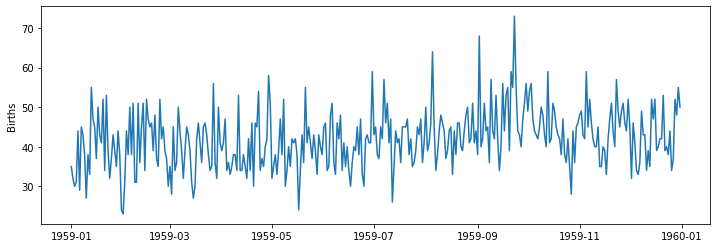

In [0]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df, y=df['Births'], x=df.index.values)
plt.show()

# CNN-LSTM for Time Series Forecasting
CNN : interpret subsequence of input  
LSTM : piece together in interpretations from subsequences  
My choice : 4 subsequences of 2 timessteps = 8 timesteps input

In [4]:
data = df.loc[:,['Births']].values
data.shape

(365, 1)

Create dataset X and y for LSTM :  
X is the values of 8 days before the current day (4D array : [samples, subsequences,timesteps,features]).  
My choice : 4 subsequences of 2 timessteps = 8 timesteps input.  
y is the current births (1D array).

In [0]:
look_back = 8
subsequences = 4
subsequence_timesteps = int(look_back/subsequences)
X = []
y = []
for i in range(look_back,data.shape[0]):
  X.append(data[i-look_back : i])
  y.append(data[i])
X = np.array(np.reshape(X, (len(X),subsequences,subsequence_timesteps,1)))
y = np.array(y)

In [39]:
print('X shape : ', X.shape)
print('y shape : ', y.shape)

X shape :  (357, 4, 2, 1)
y shape :  (357, 1)


Train-test-split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Create LSTM  
CNN : learn subsequences, then must be wrapped in TimeDistributed layer

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.metrics import RootMeanSquaredError as rmse

In [0]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, subsequence_timesteps, X.shape[3])))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse()])

In [46]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_35 (TimeDis (None, None, 2, 64)       128       
_________________________________________________________________
time_distributed_36 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 23,179
Trainable params: 23,179
Non-trainable params: 0
_________________________________________________________________


Fit CNN-LSTM

In [0]:
history = model.fit(X_train, y_train, epochs=1000, verbose=0)

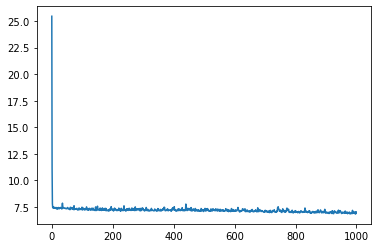

In [48]:
plt.plot(history.history['root_mean_squared_error'])
plt.show()

In [49]:
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train score (loss) : ', train_score[0])
print('Train score (rmse) : ', train_score[1])

Train score (loss) :  46.25143368369655
Train score (rmse) :  6.800840377807617


Prediction

In [0]:
y_pred = model.predict(X_test, verbose=0)

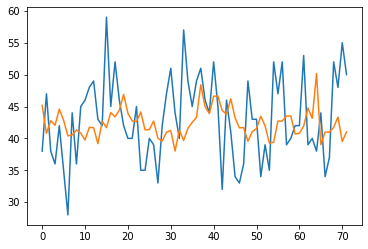

In [51]:
plt.plot(y_test)
plt.plot(y_pred)
plt.show()

In [52]:
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test score (loss) : ', test_score[0])
print('Test score (rmse) : ', test_score[1])

Test score (loss) :  49.21159532335069
Test score (rmse) :  7.015097618103027
